In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
plt.style.use('seaborn')
sns.set(style='white', context='notebook')
# sns.set(style='white', context='notebook', palette='deep') -> style white 하면 plot 의 파란 배경이 없어짐
# plt.style.use 랑 차이점? 
# seaborn 세팅
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')
IDtest = test['PassengerId']

In [3]:
# outlier Detection

def detect_outliers(df, n, features):
    '''
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observation containing more than outliers according
    to the Tukey method
    '''
    outlier_indices=[]
    
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3-Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        # Determine a list of indices of outlier for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers

Outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])

In [4]:
# outlier 라고 판단되는 데이터들
Outliers_to_drop

[27, 88, 159, 180, 201, 324, 341, 792, 846, 863]

In [5]:
train.loc[Outliers_to_drop] # show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


### 위에가 찾아낸 outlier. 숫자형 변수인 age, sibsp, parch, fare 에서 outlier 라고 판단되는 것들 -> 삭제할 것

In [6]:
# drop outliers
train = train.drop(Outliers_to_drop, axis = 0 ).reset_index(drop=True)
# 행 삭제(axis=0), 인덱스 리셋. 원래있던 것은 삭제(drop=True)

In [7]:
# joining train and test set
train_len=len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)
# len() : 길이 legth
# concat() : 동일한 열을 가지고 있음. 그래서 위, 아래로 데이터 합침. 

In [8]:
# check for null and missing values
dataset = dataset.fillna(np.nan)
dataset.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [9]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [10]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [12]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


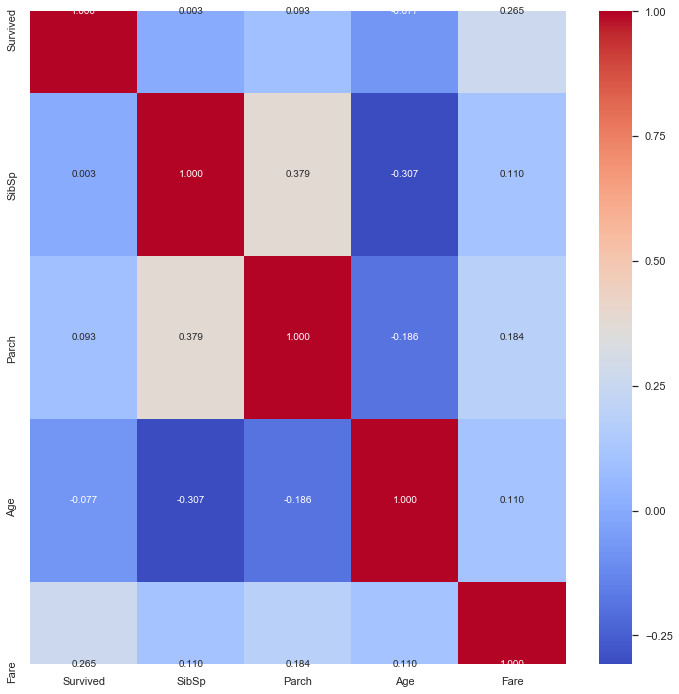

In [13]:
# Feature analysis
# Numerical values
plt.figure(figsize=(12,12))
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt='.3f', cmap='coolwarm')
# fmt에 '.2f' 소수점 몇 째짜리 까지 나타낼 것인지. .2f 면 둘째자리, .3f 면 셋째 자리

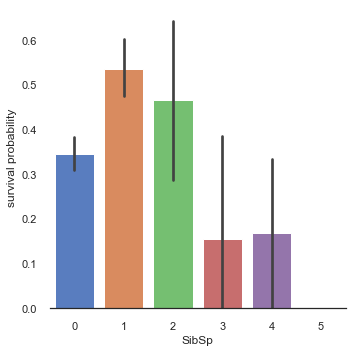

In [14]:
# SibSp
g = sns.factorplot(x='SibSp', y='Survived', data=train, kind='bar', size=5, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

# despine : remove the top and right spines from plot -> 축 line 을 지워줌. True - 삭제, default 는 False 
# spine 은 척추, 등뼈 라고 나오는데 plot의 테두리, 축 line 을 말함.
# kind 설정 안하면 점이랑 선이랑 있는 걸로 나옴. kind - point, bar, count, box, violin, strip
# size : Height of each facet. 그래프 크기를 말함.  

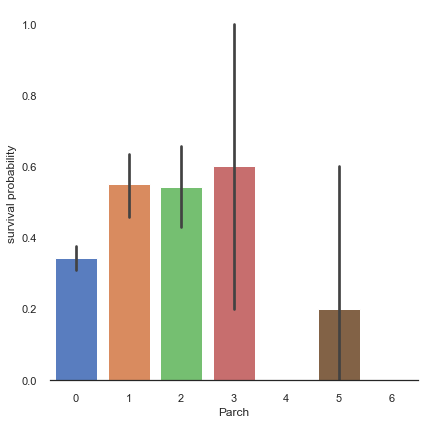

In [15]:
# Parch
g = sns.factorplot(x='Parch', y='Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

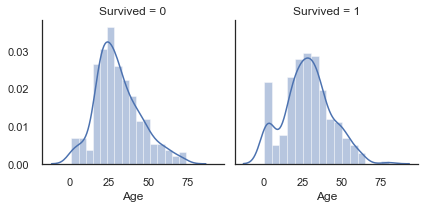

In [16]:
# Age
g = sns.FacetGrid(train, col='Survived') # data, col(변수 subset)
g = g.map(sns.distplot, 'Age')
# FacetGrid : multi-plot gird for plotting conditional relationship.
# distplot : 히스토그램 + kdeplot (or rugplot)

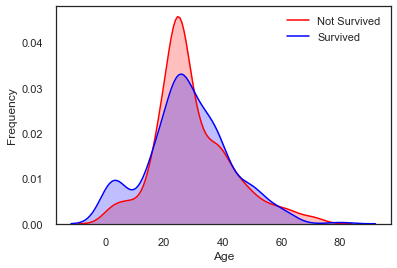

In [123]:
# 나이 분포 확인.
g = sns.kdeplot(train['Age'][(train['Survived']==0) & (train['Age'].notnull())], 
               color='Red', shade=True)
g = sns.kdeplot(train['Age'][train['Survived']==1 & train['Age'].notnull()], 
               color='Blue', shade=True, ax=g)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])
# ax를 따로 설정해주지 않아도 같은 공간에 할 수 있음.
# shade : 면을 색 칠해주는지 안해주는지 True->칠해줌. False 안해줌. default False

In [18]:
dataset['Fare'].isnull().sum()

1

In [19]:
# fill fare missing values with the median value
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())
# 하나 있는 결측치를 중간값으로 채워넣었음.

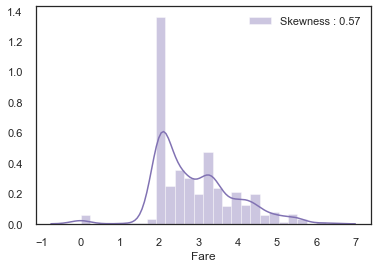

In [129]:
# explore Fare distribution - fare 는 연속형 변수이기 때문에 가능
g = sns.distplot(dataset['Fare'], color='m', label='Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

In [21]:
dataset['Fare'] = dataset['Fare'].map(lambda i : np.log(i) if i > 0 else 0)

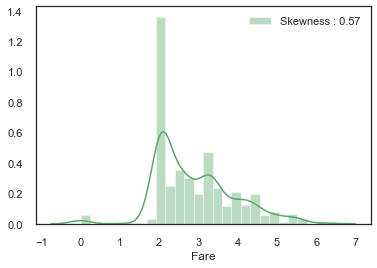

In [22]:
# 로그 스케일링
g = sns.distplot(dataset['Fare'], color='g', label='Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

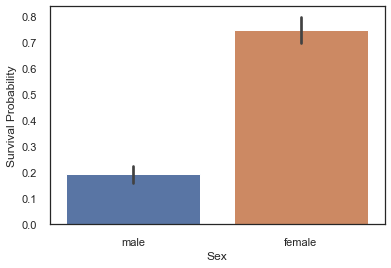

In [23]:
# categorical values
# sex
g = sns.barplot(x='Sex', y='Survived', data=train)
g = g.set_ylabel('Survival Probability')

In [24]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


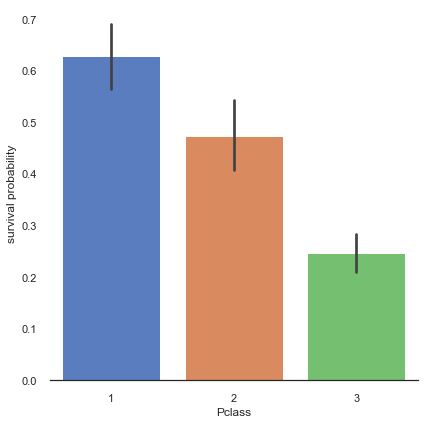

In [25]:
# Pclass
g = sns.factorplot(x='Pclass', y='Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

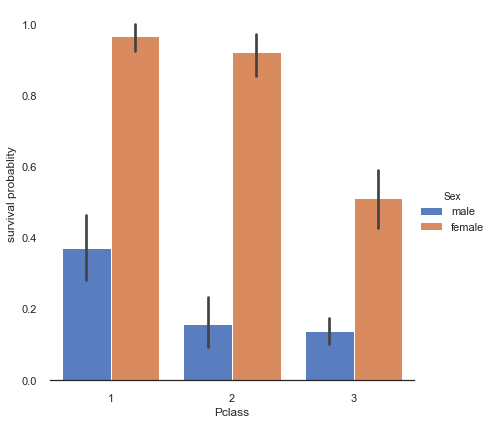

In [26]:
g = sns.factorplot(x='Pclass', y='Survived', hue='Sex', data=train, size=6, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probablity')

In [27]:
dataset['Embarked'].isnull().sum()

2

In [28]:
dataset['Embarked'] = dataset['Embarked'].fillna('S')

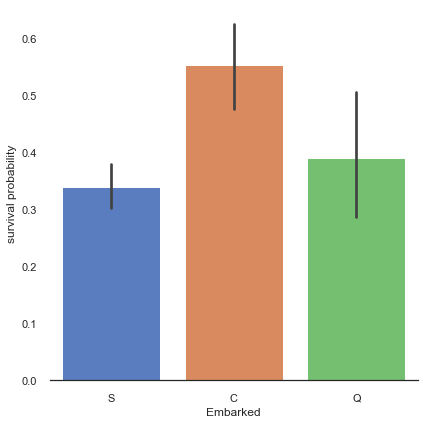

In [29]:
g = sns.factorplot(x='Embarked', y='Survived', data=train, size=6, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

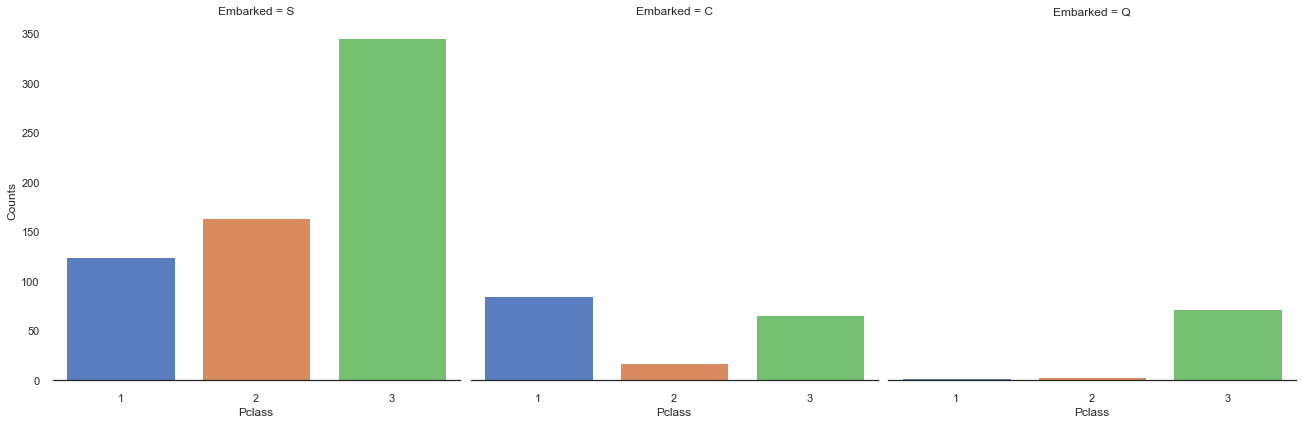

In [30]:
g = sns.factorplot('Pclass', col='Embarked', data=train, size=6, kind='count', palette='muted')
g.despine(left=True)
g = g.set_ylabels('Counts')

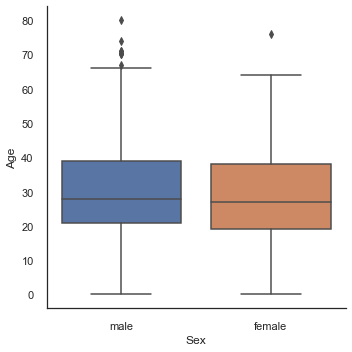

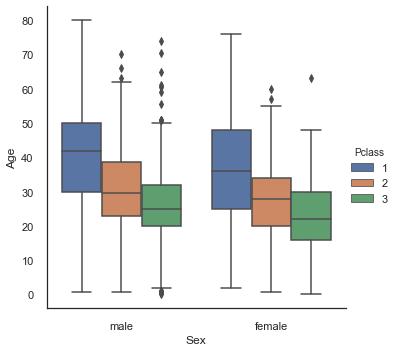

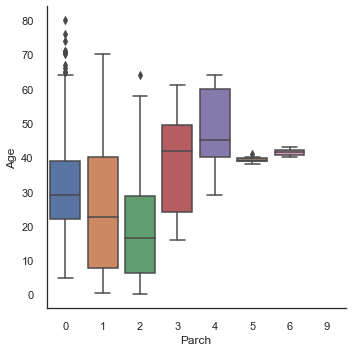

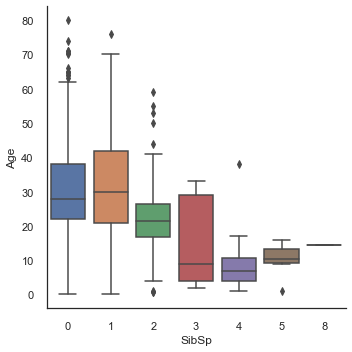

In [31]:
g = sns.factorplot(y='Age', x='Sex', data=dataset, kind='box')
g = sns.factorplot(y='Age', x='Sex', hue='Pclass', data=dataset, kind='box')
g = sns.factorplot(y='Age', x='Parch', data=dataset, kind='box')
g = sns.factorplot(y='Age', x='SibSp', data=dataset, kind='box')

In [32]:
dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})

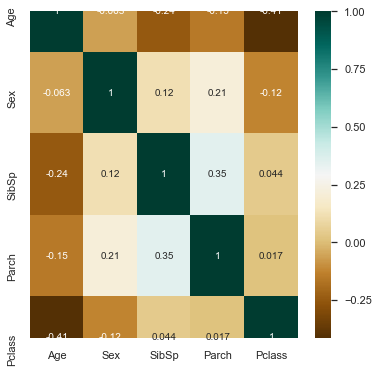

In [33]:
plt.figure(figsize=(6,6))
g = sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), cmap='BrBG', annot=True)

In [34]:
# fill missing value of age
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)
# print(index_NaN_age)

for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][((dataset['SibSp'] == dataset.iloc[i]['SibSp']) & (dataset['Parch'] == dataset.iloc[i]['Parch']) & 
                              (dataset['Pclass'] == dataset.iloc[i]['Pclass']))].median()
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

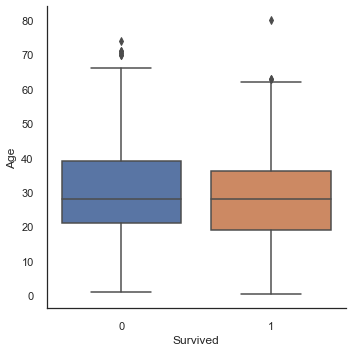

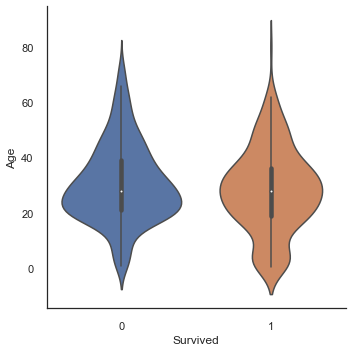

In [35]:
g = sns.factorplot(x='Survived', y='Age', data=train, kind='box')
g = sns.factorplot(x='Survived', y='Age', data=train, kind='violin')
# 두 그래프가 시사하는 바는 비슷하지만 바이올린 플롯은 생존 집단의 어린 탑승객들이 있음을 포함해서 보여줌.

In [36]:
# Feature engineering
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [37]:
# get title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()
# split() : 괄호 안에 비우면 공백을 기준으로 문자열을 나눠줌. 괄호 안에 특정 값이 있을 경우 그 값을 구분자로 해서 문자열을 나누어 줌. []기호는 순서를 말하는 것 같음.
# [1] 이니까 , 기준으로 나누었을 때 [a,b,c] 이렇게 나오는데 그 중에서 2번째 단어를 잡아내고 싶으니까 1로 잡고 그 문자를 또 . 으로 나눠서 이번에는 첫번째 단어를 추출하는 것을 의미.
# 그리고 이제 strip 으로 양쪽 공백 삭제
# strip() : 양쪽 공백 지우기

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

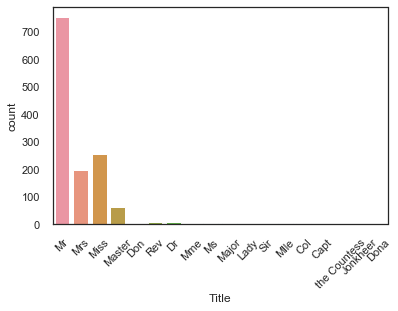

In [38]:
g = sns.countplot(x='Title', data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)
# 4가지 범주를 제외하고는 거의 없다는 것을 알 수 있음. 나머지를 통합시키자.

In [39]:
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

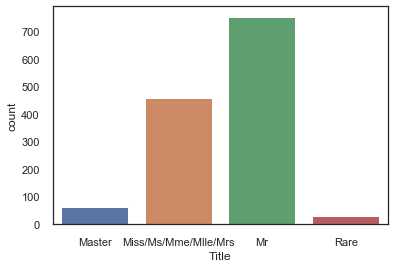

In [40]:
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(['Master', 'Miss/Ms/Mme/Mlle/Mrs', 'Mr', 'Rare'])

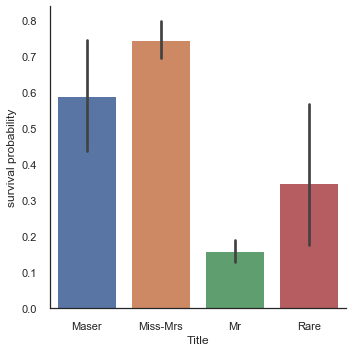

In [41]:
g = sns.factorplot(x='Title', y='Survived', data=dataset, kind='bar')
g = g.set_xticklabels(['Maser', 'Miss-Mrs', 'Mr', 'Rare'])
g = g.set_ylabels('survival probability')

Women and children first

In [42]:
# drop name variable
dataset.drop(labels = ['Name'], axis = 1, inplace = True)

In [43]:
# Family size
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1 # 자기 자신

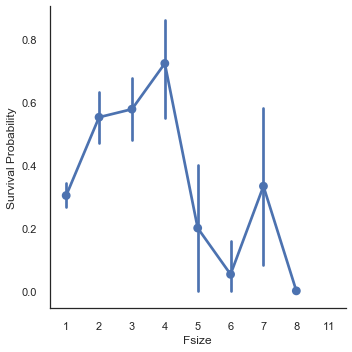

In [44]:
g = sns.factorplot(x='Fsize', y='Survived', data=dataset)
g = g.set_ylabels('Survival Probability')
# family size 가 어느 정도 연관성이 있어보임.

In [45]:
# 다양한 방법이 있지만 여기서는 map 과 lambda 이용
dataset['Single'] = dataset['Fsize'].map(lambda s:1 if s==1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s:1 if s==2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s:1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s:1 if s >=5 else 0)

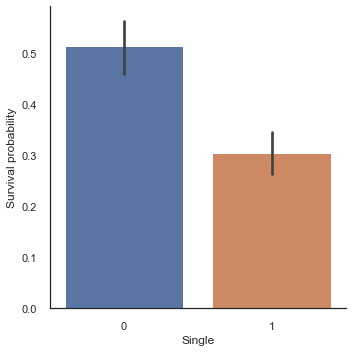

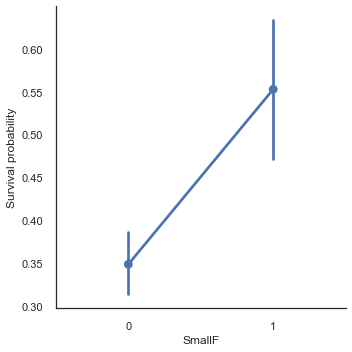

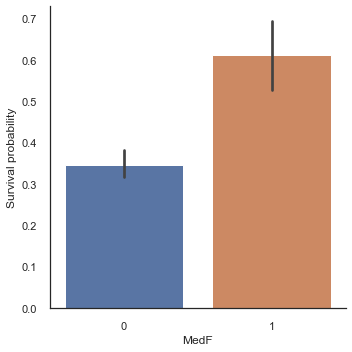

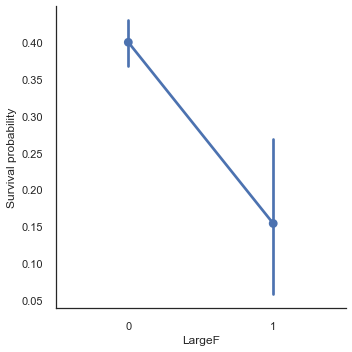

In [46]:
g = sns.factorplot(x='Single', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival probability')
g = sns.factorplot(x='SmallF', y='Survived', data=dataset)
g = g.set_ylabels('Survival probability')
g = sns.factorplot(x='MedF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival probability')
g = sns.factorplot(x='LargeF', y='Survived', data=dataset)
g = g.set_ylabels('Survival probability')

In [47]:
dataset = pd.get_dummies(dataset, columns = ['Title'])
dataset = pd.get_dummies(dataset, columns = ['Embarked'], prefix='Em')

In [48]:
dataset.head(3)

,Age,Cabin,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,22.0,NaN,1.981001,0,1,3,0,1,0.0,A/5 21171,...,1,0,0,0,0,1,0,0,0,1
1,38.0,C85,4.266662,0,2,1,1,1,1.0,PC 17599,...,1,0,0,0,1,0,0,1,0,0
2,26.0,NaN,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,...,0,0,0,0,1,0,0,0,0,1


In [49]:
# Cabin
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [51]:
dataset['Cabin'].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [52]:
# null 값 확인해서 개수 합
dataset['Cabin'].isnull().sum()

1007

In [54]:
# null 아닌 값 확인해서 개수 합
dataset['Cabin'].notnull().sum()

292

In [53]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [55]:
# replace the cabin number by the type of cabin 'X' if not
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

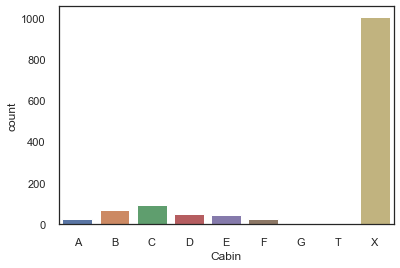

In [56]:
g = sns.countplot(dataset['Cabin'], order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])

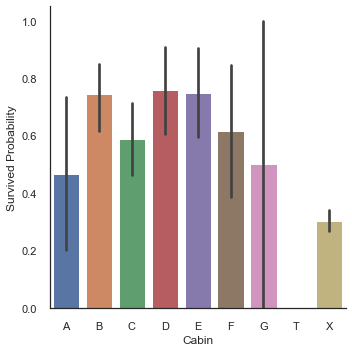

In [59]:
g = sns.factorplot(y='Survived', x='Cabin', data=dataset, kind='bar', order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])
g = g.set_ylabels('Survived Probability')
# 객실 결측치가 많지만 있는 걸로 정보를 확인해보면 이렇게 됨.

In [61]:
dataset=pd.get_dummies(dataset, columns=['Cabin'], prefix = 'Cabin')

In [60]:
# Ticket
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [62]:
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace(".", "").replace("/", "").strip().split(' ')[0])
    else:
        Ticket.append('X')
        
dataset['Ticket'] = Ticket
dataset['Ticket'].head()

# replace 연속으로 이어서 사용 가능. 

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [63]:
# kernel 에는 없는데 이걸 확인해서 정리해서 하면 좋을 것 같음.
# 그대로 쓰기에는 더미변수가 너무 많이 생성됨. 
dataset['Ticket'].value_counts()

X          954
PC          92
CA          61
A5          28
SOTONOQ     24
WC          15
SCPARIS     14
STONO       14
A4          10
FCC          9
C            8
SOC          8
SOPP         7
STONO2       7
SCParis      5
SCAH         5
WEP          4
PP           4
LINE         4
SOTONO2      3
FC           3
SCA4         2
SWPP         2
SC           2
PPP          2
CASOTON      1
AQ4          1
AS           1
SCA3         1
AQ3          1
SOP          1
A            1
Fa           1
STONOQ       1
SCOW         1
SP           1
LP           1
Name: Ticket, dtype: int64

In [64]:
# 더미변수를 몇가지 카테고리로 정리한 후 진행하면 좋겠지만 일단 그대로 실시
dataset = pd.get_dummies(dataset, columns=['Ticket'], prefix='T')

In [65]:
dataset.head()
# 66개의 column 생성 -> 너무 많은 것 같은데 정리를 하거나 불필요한 행 정리가 필요하지 않을까? 

,Age,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Fsize,Single,...,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X
0,22.0,1.981001,0,1,3,0,1,0.0,2,0,...,0,0,0,0,0,0,0,0,0,0
1,38.0,4.266662,0,2,1,1,1,1.0,2,0,...,0,0,0,0,0,0,0,0,0,0
2,26.0,2.070022,0,3,3,1,0,1.0,1,1,...,0,0,0,0,1,0,0,0,0,0
3,35.0,3.972177,0,4,1,1,1,1.0,2,0,...,0,0,0,0,0,0,0,0,0,1
4,35.0,2.085672,0,5,3,0,0,0.0,1,1,...,0,0,0,0,0,0,0,0,0,1


In [66]:
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns = ['Pclass'], prefix='Pc')

In [67]:
# drop useless variables
dataset.drop(labels = ['PassengerId'], axis=1, inplace= True)

In [68]:
dataset.head()

,Age,Fare,Parch,Sex,SibSp,Survived,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,0,1,0.0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,1,0,1.0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,35.0,2.085672,0,0,0,0.0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


## Modeling
분석 모델링

In [69]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels = ['Survived'], axis=1, inplace=True)

In [73]:
# train_len 은 위에서 정의해놨음. trian set 의 길이
# dataset[:train_len] 은 train set 길이까지 low 조회, 열은 모두 조회, 특정 열만 지정하고 싶으면 , 하고 원하는 열 범위 작성해주면 됨. 
dataset[:train_len]

,Age,Fare,Parch,Sex,SibSp,Survived,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,0,1,0.0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,1,0,1.0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,35.0,2.085672,0,0,0,0.0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,27.0,2.564949,0,0,0,0.0,1,1,0,0,...,0,0,0,0,0,0,1,0,1,0
877,19.0,3.401197,0,1,0,1.0,1,1,0,0,...,0,0,0,0,0,0,1,1,0,0
878,13.5,3.154870,2,1,1,0.0,4,0,0,1,...,0,0,0,0,1,0,0,0,0,1
879,26.0,3.401197,0,0,0,1.0,1,1,0,0,...,0,0,0,0,0,0,1,1,0,0


In [80]:
# Separate train features and labels
train['Survived'] = train['Survived'].astype(int) # Survived cilumn type 변경
Y_train = train['Survived']                       # Y 는 Survived column 만 존재
X_train = train.drop(labels = ['Survived'], axis=1) # 독립변수들만 남아있음. 

In [77]:
# simple modeling
# cross validate data
# 10개의 모델을 사용하여 성능을 비교하려고 한다.
# SVC, Deciseion Tress, AdaBoost, Random Forest, Extra Trees, Gradient Boost, Multiple layer percepton(neural network), KNN, Logistic regression, Linear Discriminant analysis
# 교차검증 https://homeproject.tistory.com/m/6 참고
kfold = StratifiedKFold(n_splits = 10) # fold 10개로 만듬. 

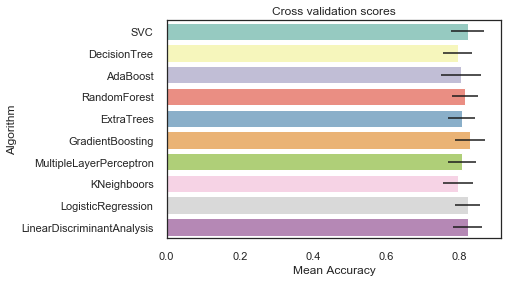

In [84]:
# Modeling step Test differents algorithms
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1))
# AdaBoostClassifier ?
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = 'accuracy', cv=kfold, n_jobs=4))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({'CrossValMeans':cv_means, 'CrossValerrors': cv_std, 'Algorithm':['SVC', 'DecisionTree', 'AdaBoost', 'RandomForest', 'ExtraTrees', 'GradientBoosting', 'MultipleLayerPerceptron', 'KNeighboors', 'LogisticRegression', 'LinearDiscriminantAnalysis']})
    
g = sns.barplot('CrossValMeans', 'Algorithm', data=cv_res, palette='Set3', orient = 'h', **{'xerr':cv_std})
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross validation scores')

# 공부할게 많음. 대시보드 시각화

## 파라메타 조정하는 단계가 있는데 cpu 4대로 15분 걸렸음. -> 시간 오래 걸릴거 같아서 스킵

In [115]:
# ada boost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)
# 밑에 파라메타 어떻게 하는지 모르겠음. 리스트?
ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  43 tasks      | elapsed:   23.5s
[Parallel(n_jobs=4)]: Done 629 tasks      | elapsed:   31.7s
[Parallel(n_jobs=4)]: Done 1113 out of 1120 | elapsed:   39.8s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:   39.8s finished


In [117]:
gsadaDTC.best_score_

0.8240635641316686

In [119]:
# Extra Trees
ExtC = ExtraTreesClassifier()

ex_param_grid = {'max_depth': [None],
                'max_features': [1,3,10],
                'min_samples_split': [2,3,10],
                'min_samples_leaf': [1,3,10],
                'boostrap': [False],
                'n_estimators': [100, 300],
                'criterion': ['gini']}

gsExtC = GridSearchCV(ExtC, param_grid = ex_param_grid, cv=kfold, scoring='accuracy', 
                     n_jobs=4, verbose = 1)

gsExtC.fit(X_train, Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


ValueError: Invalid parameter boostrap for estimator ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators='warn',
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False). Check the list of available parameters with `estimator.get_params().keys()`.

In [120]:
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   28.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  2.9min finished


0.8320090805902384

In [113]:
# plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, 
                       n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
    esimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color='r')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Trainin score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    
    plt.legend(loc='best')
    return plt

g = plot_learning_curve(gsRFC.best_estimator_, 'RF learning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_, 'ExtraTrees learning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_, 'SVC learning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_, 'AdaBoost learning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_, 'GradientBoosting learning curves', X_train, Y_train, cv=kfold)
# 위에서 수정된 모델이 정의가 안되서 안돌아감.

NameError: name 'gsRFC' is not defined